# Visualizing Sequence as Video
AMASS uses [MoSh++](https://amass.is.tue.mpg.de) pipeline to fit [SMPL+H body model](https://mano.is.tue.mpg.de/) to a human motion capture (mocap) session. [These mocaps](https://amass.is.tue.mpg.de/dataset) are from different publicly available datasets. A single data file in amass has the parameters to control gender, pose, shape, global translation and soft tissue dynamics in correspondence with the original motion capture sequence. Here we present code snippets to create a body image with these parameters. Since a mocap is a time sequence you visualize the "moshed" per frame results.

In [1]:
# Preparing the environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

import sys, os
import torch
import numpy as np

from human_body_prior.tools.omni_tools import copy2cpu as c2c

In [2]:
# Choose the device to run the body model on.
comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We assume you have downloaded the required body model and put that in body_models directory of this repository.
For SMPL-H download it from http://mano.is.tue.mpg.de/ and DMPLs you can obtain from http://smpl.is.tue.mpg.de/downloads.
If you use any of these models in your research please follow their respective citation rules.
One thing to note is that you can obtain basic SMPL+H model from their [website](http://mano.is.tue.mpg.de/), however, this model doesn't have dynamic shape blendshapes, e.g. DMPLs, and has only 10 betas. Doing so will reduce the accuracy of results. 

In [3]:
from human_body_prior.body_model.body_model import BodyModel

bm_path = '../body_models/smplh/male/model.npz'
dmpl_path = '../body_models/dmpls/male/model.npz'

num_betas = 10 # number of body parameters
num_dmpls = 8 # number of DMPL parameters

bm = BodyModel(bm_path=bm_path, num_betas=num_betas, num_dmpls=num_dmpls, path_dmpl=dmpl_path).to(comp_device)
faces = c2c(bm.f)

In [4]:
npz_bdata_path = '/mnt/Alfheim/Data/AMASS/EyesJapanDataset/Eyes_Japan_Dataset/kaiwa/gesture_etc-23-mobile call-kaiwa_poses.npz' # the path to body data
bdata = np.load(npz_bdata_path)
print('Data keys available:%s'%list(bdata.keys()))
print('Vector poses has %d elements for each of %d frames.'%(bdata['poses'].shape[1], bdata['poses'].shape[0]))
print('Vector dmpls has %d elements for each of %d frames.'%(bdata['dmpls'].shape[1], bdata['dmpls'].shape[0]))
print('Vector trans has %d elements for each of %d frames.'%(bdata['trans'].shape[1], bdata['trans'].shape[0]))
print('Vector betas has %d elements constant for the whole sequence.'%bdata['betas'].shape[0])
print('Mocap frequence rate is %0.2f.'%bdata['mocap_framerate'])
print('The subject of the mocap sequence is %s.'%bdata['gender'])

Data keys available:['trans', 'gender', 'mocap_framerate', 'betas', 'dmpls', 'poses']
Vector poses has 156 elements for each of 3600 frames.
Vector dmpls has 8 elements for each of 3600 frames.
Vector trans has 3 elements for each of 3600 frames.
Vector betas has 16 elements constant for the whole sequence.
Mocap frequence rate is 120.00.
The subject of the mocap sequence is female.


The provided sample data also has the original mocap marker data. In the real AMASS dataset, only markers for the test set are included. For the rest of the subsets you can obtain the marker data from their respective websites.
In the following we make PyTorch tensors for parameters controlling different part of the body model.

**Please note how pose indices for different body parts work.**

In [5]:
fId = 0
root_orient = torch.Tensor(bdata['poses'][fId:fId+1, :3]).to(comp_device) # controls the global root orientation
pose_body = torch.Tensor(bdata['poses'][fId:fId+1, 3:66]).to(comp_device) # controls the body
pose_hand = torch.Tensor(bdata['poses'][fId:fId+1, 66:]).to(comp_device) # controls the finger articulation
betas = torch.Tensor(bdata['betas'][:10][np.newaxis]).to(comp_device) # controls the body shape
dmpls = torch.Tensor(bdata['dmpls'][fId:fId+1]).to(comp_device) # controls soft tissue dynamics

Import the required files for viewing out mesh:

In [28]:
import cv2
import trimesh
from human_body_prior.tools.omni_tools import colors
from human_body_prior.mesh import MeshViewer
from human_body_prior.mesh.sphere import points_to_spheres
from ipywidgets import interact, widgets
from IPython.display import display
from PIL import Image

def show_image(img_array):
    display(Image.fromarray(img_array))
    
bg_image = Image.open('../images/ParkingLotFishBowl.jpg')
bg_array = np.array(bg_image)
print(f'Background image has shape: {bg_array.shape}')

imh, imw, _ = bg_array.shape
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

Background image has shape: (540, 720, 3)


### Visualize frame betas and pose_body
Let's see how our body looks like using the pose and body shape parameters.

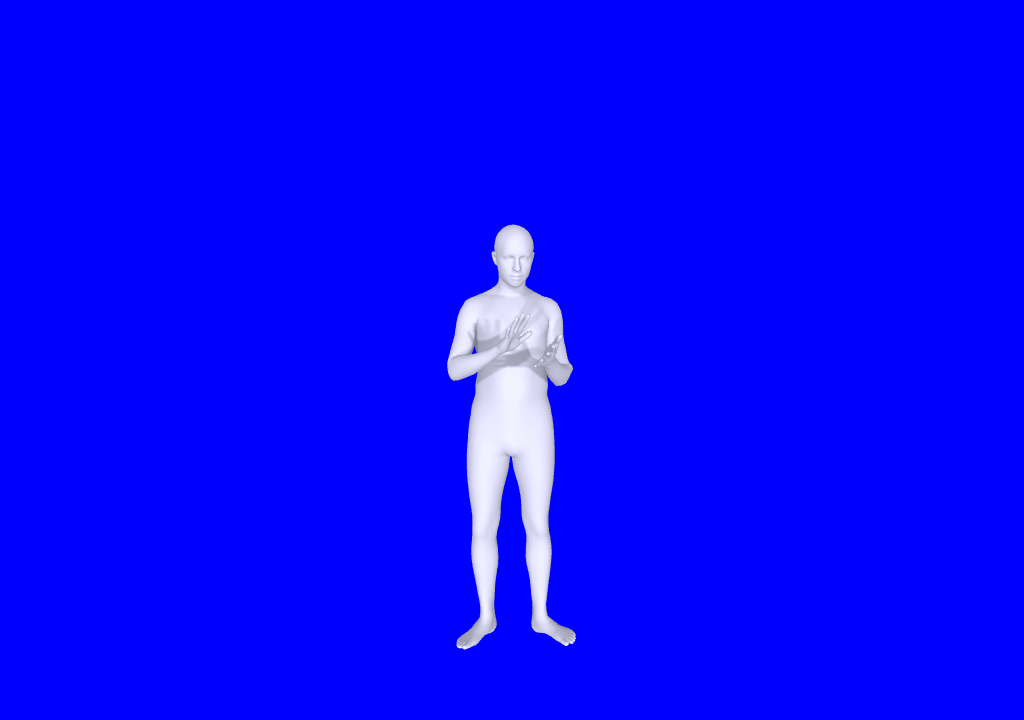

In [7]:
fId = 700 # frame id of the mocap sequence

root_orient = torch.Tensor(bdata['poses'][fId:fId+1, :3]).to(comp_device) # controls the global root orientation
pose_body = torch.Tensor(bdata['poses'][fId:fId+1, 3:66]).to(comp_device) # controls the body
betas = torch.Tensor(bdata['betas'][:10][np.newaxis]).to(comp_device) # controls the body shape

mv.set_background_color(color=(0., 0., 1.))

body = bm(pose_body=pose_body, betas=betas)
body_mesh = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['pink'], (6890, 1)))
mv.set_static_meshes([body_mesh])
body_image = mv.render(render_wireframe=False)
show_image(body_image)

In [8]:
def bluescreen2alpha(input_image):
    image_copy = np.copy(input_image)
    lower_blue = np.array([0, 0, 100, 255])          #[R, G, B]
    upper_blue = np.array([120, 100, 255, 255])      #[R, G, B]
    alpha_channel = np.invert(cv2.inRange(image_copy, lower_blue, upper_blue))
    image_copy[:,:,3] = alpha_channel
    return image_copy

In [ ]:
def display_body(frame_num):
    fId = frame_num # frame id of the mocap sequence

    root_orient = torch.Tensor(bdata['poses'][fId:fId+1, :3]).to(comp_device) # controls the global root orientation
    pose_body = torch.Tensor(bdata['poses'][fId:fId+1, 3:66]).to(comp_device) # controls the body
    betas = torch.Tensor(bdata['betas'][:10][np.newaxis]).to(comp_device) # controls the body shape
    
    mv.set_background_color(color=(0., 0., 1.)) #RGB, blue screen

    body = bm(pose_body=pose_body, betas=betas)
    body_mesh = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['pink'], (6890, 1)))
    mv.set_static_meshes([body_mesh])
    body_image = mv.render(render_wireframe=False)
    body_image = bluescreen2alpha(body_image)
    show_image(body_image)
    
interact(display_body, frame_num=widgets.IntSlider(min=0, max=bdata['poses'].shape[0]-1, step=5, value=600))

We see a male subject sitting and havig the hands open. 
Let's articulate the fingers as well:

### Visualize pose hands
To articulate fingers we use the 66:156 pose vector elements.

In [ ]:
def display_body_and_hands(frame_num):
    fId = frame_num # frame id of the mocap sequence

    root_orient = torch.Tensor(bdata['poses'][fId:fId+1, :3]).to(comp_device) # controls the global root orientation
    pose_body = torch.Tensor(bdata['poses'][fId:fId+1, 3:66]).to(comp_device) # controls the body
    pose_hand = torch.Tensor(bdata['poses'][fId:fId+1, 66:]).to(comp_device) # controls the finger articulation
    betas = torch.Tensor(bdata['betas'][:10][np.newaxis]).to(comp_device) # controls the body shape
    dmpls = torch.Tensor(bdata['dmpls'][fId:fId+1]).to(comp_device) # controls soft tissue dynamics

    body = bm(pose_body=pose_body, pose_hand=pose_hand, betas=betas)
    body_mesh = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['pink'], (6890, 1)))
    mv.set_static_meshes([body_mesh])
    body_image = mv.render(render_wireframe=False)
    show_image(body_image)
    
interact(display_body_and_hands, frame_num=widgets.IntSlider(min=0, max=bdata['poses'].shape[0]-1, step=5, value=600))

It seems that the subject is holding something with one hand.

### Visualize body joints

Our body model has also joint locations. You can read their location by accesing `Jtr` attribute of the returned body and visualize them as spheres. Here we render the body transparently to visualize the joints.

In [ ]:
body = bm(pose_body=pose_body, pose_hand = pose_hand, betas=betas)
joints = c2c(body.Jtr[0])
joints_mesh = points_to_spheres(joints, vc = colors['red'], radius=0.005)
mv.set_static_meshes([body_mesh_wfingers] + joints_mesh)
body_image_wfingers_joints = mv.render(render_wireframe=True)
show_image(body_image_wfingers_joints)

### Visualize DMPLs

You can control the soft tissue dynamics with dmpl parameters. Please have in mind, by nature of dmpl parameters being dynamic, the better appear when animation the whole sequence. Refer to full renders of the parameter sequences in our [website](https://amass.is.tue.mpg.de/).

In [ ]:
def display_dmpl(frame_num):
    fId = frame_num # frame id of the mocap sequence

    root_orient = torch.Tensor(bdata['poses'][fId:fId+1, :3]).to(comp_device) # controls the global root orientation
    pose_body = torch.Tensor(bdata['poses'][fId:fId+1, 3:66]).to(comp_device) # controls the body
    pose_hand = torch.Tensor(bdata['poses'][fId:fId+1, 66:]).to(comp_device) # controls the finger articulation
    betas = torch.Tensor(bdata['betas'][:10][np.newaxis]).to(comp_device) # controls the body shape
    dmpls = torch.Tensor(bdata['dmpls'][fId:fId+1]).to(comp_device) # controls soft tissue dynamics

    body = bm(pose_body=pose_body, pose_hand=pose_hand, betas=betas, dmpls=dmpls)
    body_mesh = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['pink'], (6890, 1)))
    mv.set_static_meshes([body_mesh])
    body_image = mv.render(render_wireframe=False)
    show_image(body_image)
    
interact(display_dmpl, frame_num=widgets.IntSlider(min=0, max=bdata['poses'].shape[0]-1, step=5, value=600))

### Visualizing the global root orientation

In the above examples we dont use the global translation or rotation. To be able to see the subject from the front. However, we can globally control the character position and orientation with trans, and root_orient parameters respectively.

Rotation tensor is in radians in the following order: [X, Y, Z]. Where X goes to right, Y is vertical and Z is the line of the camera.

In [11]:
def display_rotation(frame_num, pitch, yaw, roll):
    fId = frame_num # frame id of the mocap sequence

    root_orient = torch.Tensor(bdata['poses'][fId:fId+1, :3]).to(comp_device) # controls the global root orientation
    pose_body = torch.Tensor(bdata['poses'][fId:fId+1, 3:66]).to(comp_device) # controls the body
    pose_hand = torch.Tensor(bdata['poses'][fId:fId+1, 66:]).to(comp_device) # controls the finger articulation
    betas = torch.Tensor(bdata['betas'][:10][np.newaxis]).to(comp_device) # controls the body shape
    dmpls = torch.Tensor(bdata['dmpls'][fId:fId+1]).to(comp_device) # controls soft tissue dynamics
    rotation = torch.tensor([[np.deg2rad(pitch), np.deg2rad(yaw), np.deg2rad(roll)]]).to(comp_device)
    
    mv.set_background_color([1., 1., 1.])

    body = bm(pose_body=pose_body, pose_hand=pose_hand, betas=betas, dmpls=dmpls, root_orient=rotation)
    body_mesh = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['pink'], (6890, 1)))
    mv.set_static_meshes([body_mesh])
    body_image = mv.render(render_wireframe=False)
    show_image(body_image)
    
interact(display_rotation, 
         frame_num=widgets.IntSlider(min=0, max=bdata['poses'].shape[0]-1, step=5, value=600),
         pitch=widgets.IntSlider(min=-360, max=360, step=5, value=0),
         yaw=widgets.IntSlider(min=-360, max=360, step=5, value=0),
         roll=widgets.IntSlider(min=-360, max=360, step=5, value=0))

interactive(children=(IntSlider(value=600, description='frame_num', max=3599, step=5), IntSlider(value=0, desc…

<function __main__.display_rotation(frame_num, pitch, yaw, roll)>

### Moving the camera accordingly

In [35]:
def display_rotation(frame_num, x, y, z, pitch, yaw, roll):
    fId = frame_num # frame id of the mocap sequence

    root_orient = torch.Tensor(bdata['poses'][fId:fId+1, :3]).to(comp_device) # controls the global root orientation
    pose_body = torch.Tensor(bdata['poses'][fId:fId+1, 3:66]).to(comp_device) # controls the body
    pose_hand = torch.Tensor(bdata['poses'][fId:fId+1, 66:]).to(comp_device) # controls the finger articulation
    betas = torch.Tensor(bdata['betas'][:10][np.newaxis]).to(comp_device) # controls the body shape
    dmpls = torch.Tensor(bdata['dmpls'][fId:fId+1]).to(comp_device) # controls soft tissue dynamics
    rotation = torch.tensor([[np.deg2rad(pitch), np.deg2rad(yaw), np.deg2rad(roll)]]).to(comp_device)
    
    tx, ty, tz = x, y, z
    camera_pose = np.array([[1., 0., 0,  tx],  
                            [0., 1., 0,  ty],
                            [0., 0., 1., tz],
                            [0., 0., 0., 1.]])
    mv.update_camera_pose(camera_pose)
    mv.set_background_color([0., 0., 1.])
    

    body = bm(pose_body=pose_body, pose_hand=pose_hand, betas=betas, dmpls=dmpls, root_orient=rotation)
    body_mesh = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['pink'], (6890, 1)))
    mv.set_static_meshes([body_mesh])
    body_image = mv.render(render_wireframe=False)
    body_image = bluescreen2alpha(body_image)
    mask = body_image[:,:,3]
    x_pos, y_pos = np.where(mask==255)
    bg = np.copy(bg_array)
    for x, y in zip(x_pos, y_pos):
        bg[x, y] = (0, 0, 0)
    
    show_image(body_image[:,:,:3] + bg)
    
interact(display_rotation, 
         frame_num=widgets.IntSlider(min=0, max=bdata['poses'].shape[0]-1, step=5, value=600),
         x=widgets.FloatSlider(min=-50, max=50, step=0.25, value=0),
         y=widgets.FloatSlider(min=-25, max=50, step=0.25, value=0),
         z=widgets.FloatSlider(min=0, max=50, step=0.25, value=1),
         pitch=widgets.IntSlider(min=-360, max=360, step=10, value=0),
         yaw=widgets.IntSlider(min=-360, max=360, step=10, value=0),
         roll=widgets.IntSlider(min=-360, max=360, step=10, value=0))

interactive(children=(IntSlider(value=600, description='frame_num', max=3599, step=5), FloatSlider(value=0.0, …

<function __main__.display_rotation(frame_num, x, y, z, pitch, yaw, roll)>

In [36]:
def render_frame(frame_num, x, y, z, pitch, yaw, roll):
    fId = frame_num # frame id of the mocap sequence

    root_orient = torch.Tensor(bdata['poses'][fId:fId+1, :3]).to(comp_device) # controls the global root orientation
    pose_body = torch.Tensor(bdata['poses'][fId:fId+1, 3:66]).to(comp_device) # controls the body
    pose_hand = torch.Tensor(bdata['poses'][fId:fId+1, 66:]).to(comp_device) # controls the finger articulation
    betas = torch.Tensor(bdata['betas'][:10][np.newaxis]).to(comp_device) # controls the body shape
    dmpls = torch.Tensor(bdata['dmpls'][fId:fId+1]).to(comp_device) # controls soft tissue dynamics
    rotation = torch.tensor([[np.deg2rad(pitch), np.deg2rad(yaw), np.deg2rad(roll)]]).to(comp_device)
    
    tx, ty, tz = x, y, z
    camera_pose = np.array([[1., 0., 0,  tx],  
                            [0., 1., 0,  ty],
                            [0., 0., 1., tz],
                            [0., 0., 0., 1.]])
    mv.update_camera_pose(camera_pose)
    mv.set_background_color([0., 0., 1.])
    

    body = bm(pose_body=pose_body, pose_hand=pose_hand, betas=betas, dmpls=dmpls, root_orient=rotation)
    body_mesh = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['pink'], (6890, 1)))
    mv.set_static_meshes([body_mesh])
    body_image = mv.render(render_wireframe=False)
    body_image = bluescreen2alpha(body_image)
    mask = body_image[:,:,3]
    x_pos, y_pos = np.where(mask==255)
    bg = np.copy(bg_array)
    for x, y in zip(x_pos, y_pos):
        bg[x, y] = (0, 0, 0)
    
    return body_image[:,:,:3] + bg

In [41]:
output_frames_dir = '../output/test'
cam_x, cam_y, cam_z = 3., 1.5, 16.5
pitch, yaw, roll = 0, 40, 0
for idx, frame_idx in enumerate(range(580, 3600, 4)):
    frame_path = os.path.join(output_frames_dir, f'{idx:05}.png')
    Image.fromarray(render_frame(frame_idx, cam_x, cam_y, cam_z, pitch, yaw, roll)).save(frame_path)